<a href="https://colab.research.google.com/github/mayank260302/Credit-Risk-Assessment/blob/main/Auto_ticket_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated NLP Pipeline for Customer Support Ticket Classification,
Sentiment Detection, and Response Generation


In [ ]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
df = pd.read_csv("customer_support_tickets.csv")
df.head()

,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich möchte eine...",Vielen Dank für die Meldung des kritischen Sic...,Incident,Technical Support,high,de,51,Security,Outage,Disruption,Data Breach,NaN,NaN,NaN,NaN
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51,Billing,Payment,Account,Documentation,Feedback,NaN,NaN,NaN
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Thank you for your inquiry. Our product suppor...,Problem,Sales and Pre-Sales,medium,en,51,Product,Feature,Feedback,Tech Support,NaN,NaN,NaN,NaN


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28587 entries, 0 to 28586
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subject   24749 non-null  object
 1   body      28587 non-null  object
 2   answer    28580 non-null  object
 3   type      28587 non-null  object
 4   queue     28587 non-null  object
 5   priority  28587 non-null  object
 6   language  28587 non-null  object
 7   version   28587 non-null  int64 
 8   tag_1     28587 non-null  object
 9   tag_2     28574 non-null  object
 10  tag_3     28451 non-null  object
 11  tag_4     25529 non-null  object
 12  tag_5     14545 non-null  object
 13  tag_6     5874 non-null   object
 14  tag_7     2040 non-null   object
 15  tag_8     565 non-null    object
dtypes: int64(1), object(15)
memory usage: 3.5+ MB


In [ ]:
df = df[df["language"] == "en"]


In [ ]:
df["text"] = df["subject"].fillna('') + " " + df["body"].fillna('')
df = df[["text", "queue"]]
df = df.rename(columns={"queue": "label"})
df = df.dropna()
df.head()


,text,label
1,"Account Disruption Dear Customer Support Team,...",Technical Support
2,Query About Smart Home System Integration Feat...,Returns and Exchanges
3,Inquiry Regarding Invoice Details Dear Custome...,Billing and Payments
4,Question About Marketing Agency Software Compa...,Sales and Pre-Sales
5,"Feature Query Dear Customer Support,\n\nI hope...",Technical Support


In [ ]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

print("Label Mapping:")
for i, class_name in enumerate(le.classes_):
    print(i, "->", class_name)


Label Mapping:
0 -> Billing and Payments
1 -> Customer Service
2 -> General Inquiry
3 -> Human Resources
4 -> IT Support
5 -> Product Support
6 -> Returns and Exchanges
7 -> Sales and Pre-Sales
8 -> Service Outages and Maintenance
9 -> Technical Support


In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    random_state=42
)


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_dict({
    "text": train_texts.tolist(),
    "label": train_labels.tolist()
})

test_dataset = Dataset.from_dict({
    "text": test_texts.tolist(),
    "label": test_labels.tolist()
})


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/13070 [00:00<?, ? examples/s]

Map:   0%|          | 0/3268 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(le.classes_)
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    save_strategy="epoch"
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,1.646916,1.655745


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss
1,1.646916,1.655745
2,1.431079,1.475700
3,1.081150,1.390874


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

print(classification_report(test_labels, pred_labels))


In [ ]:
cm = confusion_matrix(test_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

print(classification_report(test_labels, pred_labels))


              precision    recall  f1-score   support

           0       0.77      0.78      0.77       301
           1       0.40      0.43      0.41       496
           2       0.86      0.16      0.27        37
           3       0.73      0.16      0.27        68
           4       0.49      0.34      0.40       362
           5       0.44      0.47      0.46       620
           6       0.63      0.21      0.31       175
           7       0.56      0.18      0.27       127
           8       0.90      0.61      0.73       161
           9       0.53      0.74      0.61       921

    accuracy                           0.53      3268
   macro avg       0.63      0.41      0.45      3268
weighted avg       0.54      0.53      0.51      3268



Sentment Analysis

In [ ]:
from transformers import pipeline
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=device.index if device.type == "cuda" else -1 # Explicitly set device for sentiment pipeline
)

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

In [ ]:
sentiment_pipeline("I am extremely disappointed with your service.")


[{'label': 'NEGATIVE', 'score': 0.9997227787971497}]

In [ ]:
def detect_sentiment(text):
    result = sentiment_pipeline(text)[0]
    label = result["label"]
    score = result["score"]

    if label == "NEGATIVE" and score > 0.75:
        return "Angry"
    elif label == "POSITIVE" and score > 0.75:
        return "Happy"
    else:
        return "Neutral"


In [ ]:
sample_ticket = test_texts.iloc[0]
print(sample_ticket)
print("Sentiment:", detect_sentiment(sample_ticket))


Query on Data Analytics Tools for Investment Optimization Dear Customer Support, I am inquiring about the data analytics tools that are available to assist in optimizing investment strategies. Could you provide detailed information on the types of tools that are used to make informed investment decisions? I would greatly appreciate any information provided, including relevant resources and recommendations. Thank you for your assistance, and I look forward to hearing from you soon. Please let me know if any additional information is needed.
Sentiment: Happy


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


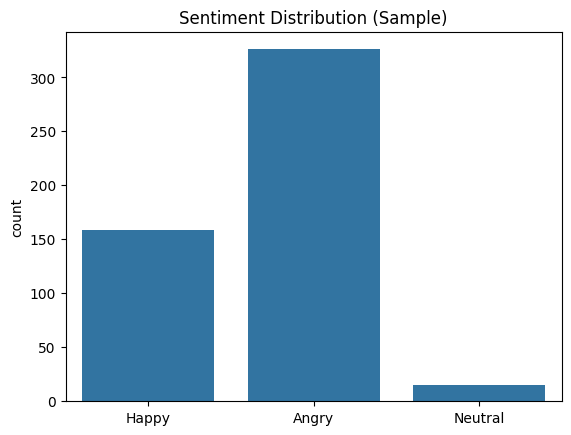

In [ ]:
sentiments = [detect_sentiment(text) for text in test_texts[:500]]

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=sentiments)
plt.title("Sentiment Distribution (Sample)")
plt.show()


Phase 3 Response Generation

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

generator_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
generator_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")


Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


In [ ]:
def generate_basic_reply(ticket):
    prompt = f"""
    Generate a polite and professional customer support reply to the following ticket:

    Ticket: {ticket}
    """

    inputs = generator_tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = generator_model.generate(**inputs, max_length=150)

    return generator_tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator_model.to(device)

def generate_basic_reply(ticket):
    prompt = f"""
    Generate a polite and professional customer support reply to the following ticket:

    Ticket: {ticket}
    """

    inputs = generator_tokenizer(prompt, return_tensors="pt", truncation=True).to(device) # Move entire BatchEncoding to device
    outputs = generator_model.generate(**inputs, max_length=150)

    return generator_tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generate_basic_reply("My payment failed but money was deducted."))

I'm sorry to hear that. I'm sorry to hear about your experience. We will contact you shortly with more information. (Exchange: £20 $70 $60 $60 $60 $60 $80 $80 $90 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 $80 


In [ ]:
print(generate_basic_reply("My payment failed but money was deducted."))


I'm sorry to hear that. I hope this helps you.


In [ ]:
import torch

# Ensure the classification model is on the correct device (GPU if available, else CPU)
# The `device` variable was defined in cell NJQ2_XXgUDYg
model.to(device) # This ensures the classification model is on the same device as generator_model

def support_pipeline(ticket):
    # 1. Ticket Classification
    inputs = tokenizer(ticket, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()} # Move inputs to the device

    with torch.no_grad(): # No need to calculate gradients for inference
        outputs = model(**inputs)
        category_id = torch.argmax(outputs.logits, dim=1).item()
        category = le.inverse_transform([category_id])[0]

    # 2. Sentiment Detection
    sentiment = detect_sentiment(ticket)

    # 3. Response Generation
    reply = generate_basic_reply(ticket)

    return {
        "Category": category,
        "Sentiment": sentiment,
        "Reply": reply
    }

test_ticket = "I am extremely frustrated. My refund has not been processed."
result = support_pipeline(test_ticket)
print(result)

{'Category': 'Billing and Payments', 'Sentiment': 'Angry', 'Reply': "I'm so sorry."}


In [ ]:
def generate_smart_reply(ticket, category, sentiment):
    prompt = f"""
    You are a professional customer support assistant.

    Category: {category}
    Customer Sentiment: {sentiment}

    Ticket: {ticket}

    Generate a polite, empathetic, and helpful response.
    """

    inputs = generator_tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = generator_model.generate(**inputs, max_length=200)

    return generator_tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
def generate_reply(ticket, category, sentiment):
    prompt = f"""
You are a professional customer support agent.

Category: {category}
Customer Sentiment: {sentiment}
Customer Ticket: {ticket}

Write a detailed, polite, non-repetitive professional response.
"""

    inputs = generator_tokenizer(prompt, return_tensors="pt", truncation=True)

    outputs = generator_model.generate(
        **inputs,
        max_length=200,
        num_beams=4,                # better beam search
        no_repeat_ngram_size=3,     # prevents repetition
        repetition_penalty=1.5,     # penalizes repeating phrases
        early_stopping=True
    )

    return generator_tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
def generate_reply(ticket, category, sentiment):
    prompt = f"""
You are a professional customer support agent.

Category: {category}
Customer Sentiment: {sentiment}
Customer Ticket: {ticket}

Write a detailed, polite, non-repetitive professional response.
"""

    inputs = generator_tokenizer(prompt, return_tensors="pt", truncation=True)

    outputs = generator_model.generate(
        **inputs,
        max_length=200,
        num_beams=4,                # better beam search
        no_repeat_ngram_size=3,     # prevents repetition
        repetition_penalty=1.5,     # penalizes repeating phrases
        early_stopping=True
    )

    return generator_tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
from datasets import load_dataset

bitext_dataset = load_dataset(
    "bitext/Bitext-customer-support-llm-chatbot-training-dataset"
)

bitext_dataset


DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 26872
    })
})

In [ ]:
bitext_dataset["train"].to_pandas().head()


,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


In [ ]:
small_dataset = bitext_dataset["train"].select(range(3000))


In [ ]:
def preprocess_function(example):
    input_text = "Customer query: " + example["instruction"]
    target_text = example["response"]

    model_inputs = generator_tokenizer(
        input_text,
        max_length=256,
        truncation=True,
        padding="max_length"
    )

    labels = generator_tokenizer(
        target_text,
        max_length=256,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


In [ ]:
tokenized_dataset = small_dataset.map(
    preprocess_function,
    batched=False
)

tokenized_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)


In [ ]:
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = tokenized_dataset.train_test_split(
    test_size=0.1
).values()


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./flan_t5_results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs", # Reverted to logging_dir to fix TypeError
    fp16=True  # Important for GPU speed
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=generator_tokenizer,
    model=generator_model
)


In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./flan_t5_results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=1,
    fp16=True
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=generator_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.000000,nan
2,0.000000,nan


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=1350, training_loss=0.0, metrics={'train_runtime': 791.8798, 'train_samples_per_second': 6.819, 'train_steps_per_second': 1.705, 'total_flos': 1848844851609600.0, 'train_loss': 0.0, 'epoch': 2.0})